In [1]:
import numpy as np
from keras import models
from keras import layers

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# Config parameters
det_width = 50
det_depth = 50

## Data utils

In [3]:
# This stuff needs to be moved into a module.

def sim_track(m, b):
    """Simulate hits on the detector from one track"""
    x = np.zeros([det_depth, det_width])
    hit_idxs = [round(m*l + b) for l in range(det_depth)]
    for row, idx in enumerate(hit_idxs):
        x[row, idx] = 1
    return x

def generate_track():
    """Sample track parameters and simulate propagation to produce hits"""
    b = np.random.random_sample()*(det_width - 1)
    # restrict slope to only generate tracks that traverse the entire detector
    mmax = (det_width - 1 - b) / (det_depth - 1)
    mmin = -b / det_depth
    m = np.random.random_sample() * (mmax - mmin) + mmin
    return sim_track(m, b)

def generate_tracks(n):
    """Generates N tracks in independent detector images"""
    tracks = [generate_track().reshape([1, det_depth, det_width]) for i in range(n)]
    return np.concatenate(tracks, axis=0)

def generate_noise(n, prob=0.1, skip_layers=5):
    """Generate uniform noise hits with probability prob and skipping some initial seed layers"""
    # One way to do this: generate random floats in [0,1]
    # and then convert the ones above threshold to binary
    noise_events = np.zeros([n, det_depth, det_width])
    noise_events[:,skip_layers:,:] = np.random.random_sample([n, det_depth-skip_layers, det_width]) < prob
    return noise_events

def generate_events(num_event, tracks_per_event):
    """Generates events with fixed number of tracks"""
    return sum([generate_tracks(num_event) for i in range(tracks_per_event)])

## Build the variable-width lstm model

In [4]:
# Play with setting up the complicated LSTM architecture
def build_model(widths, hidden_size,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    """
    Build a flexible lstm model which handles variable-width inputs.
    
    Inputs and outputs are split by layer. Each input feeds through a unique
    sub-network to transform to a fixed-width space. The resulting sequence is fed
    into the LSTM. The output sequence is split and each output is transformed
    through another sub-network to the target layer's width.
    """
    inputs = [layers.Input(shape=(w,)) for w in widths[0:-1]]
    hidden1 = [layers.Reshape((1, hidden_size))(layers.Dense(hidden_size)(i)) for i in inputs]
    sequence = layers.merge(hidden1, mode='concat', concat_axis=1)
    hidden2 = layers.LSTM(output_dim=hidden_size, return_sequences=True)(sequence)
    hidden2_split = [layers.Lambda(lambda x: x[:,i,:])(hidden2)
                     for i in range(hidden2.get_shape()[1])]
    outputs = [layers.Dense(w, activation='softmax')(h)
               for (w, h) in zip(widths[1:], hidden2_split)]
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Reproduce simple experiment results

Let's verify that this network can handle the simple fixed-width 1D detector case.

In [7]:
# Generate the data, single tracks
tracks = generate_tracks(50000)
train_input = tracks[:,:-1,:]
train_inputs = [train_input[:,i,:] for i in range(det_depth-1)]
train_target = tracks[:,1:,:]
train_targets = [train_target[:,i,:] for i in range(det_depth-1)]
print(train_input.shape)

(50000, 49, 50)


In [8]:
widths = [det_width for i in range(det_depth)]
model = build_model(widths, 20)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 50)            0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 50)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 50)            0                                            
___________________________________________________________________________________________

In [11]:
# Train on the entire training set
model.fit(train_inputs, train_targets, batch_size=100, nb_epoch=10)

Epoch 1/10
50000/50000 [==============================] - 244s - loss: 97.7745 - dense_50_loss: 2.0339 - dense_51_loss: 1.8917 - dense_52_loss: 1.8841 - dense_53_loss: 1.8756 - dense_54_loss: 1.8973 - dense_55_loss: 1.9378 - dense_56_loss: 1.9250 - dense_57_loss: 1.9222 - dense_58_loss: 1.9098 - dense_59_loss: 1.9676 - dense_60_loss: 1.9378 - dense_61_loss: 2.0044 - dense_62_loss: 1.9575 - dense_63_loss: 1.9935 - dense_64_loss: 2.0305 - dense_65_loss: 2.0313 - dense_66_loss: 1.9988 - dense_67_loss: 1.9966 - dense_68_loss: 2.0269 - dense_69_loss: 2.0204 - dense_70_loss: 1.9967 - dense_71_loss: 2.0441 - dense_72_loss: 2.0442 - dense_73_loss: 2.0371 - dense_74_loss: 2.0263 - dense_75_loss: 2.0782 - dense_76_loss: 2.1297 - dense_77_loss: 2.1154 - dense_78_loss: 2.0565 - dense_79_loss: 2.0403 - dense_80_loss: 2.0523 - dense_81_loss: 2.0711 - dense_82_loss: 2.0307 - dense_83_loss: 2.0118 - dense_84_loss: 1.9976 - dense_85_loss: 2.0255 - dense_86_loss: 2.0463 - dense_87_loss: 2.0466 - dense_8

In [12]:
# Get all of the training data predictions
train_preds = model.predict(train_inputs)

In [13]:
def convert_to_image(data, idx):
    return np.concatenate([d[idx,:].reshape(1, -1) for d in data])

In [14]:
display_idx = 10
pred_layers = [pred[display_idx,:] for pred in train_preds]
pred_layers[0].shape
pred_layers = [layer.reshape(1, -1) for layer in pred_layers]
pred_layers[0].shape
pred = np.concatenate(pred_layers)
#pred = np.concatenate([pred[display_idx,:].reshape(1, det_depth-1, det_width) for pred in train_preds])

pred = convert_to_image(train_preds, 10)
inp = convert_to_image(train_inputs, 10)

<IPython.core.display.Javascript object>


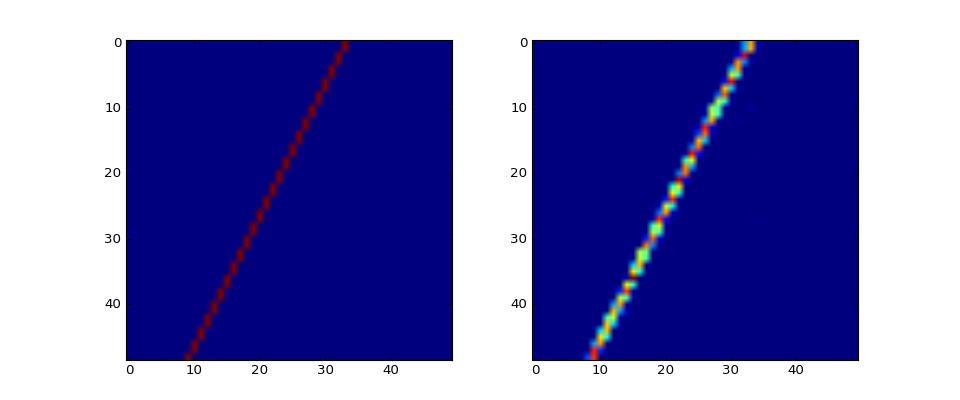

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(inp)
plt.subplot(122)
plt.imshow(pred)

## Trapezoid detector
The complicated LSTM architecture worked on the simple case! Now let's see how it will work on the more realistic case.

Consider a detector whose width increases with each layer, like a wedge section of a concentric-circles detector. Many such problems can be mapped onto a trapezoidal shape.

In [5]:
def detector_zeroes(widths):
    """Return the list of layers initialized to zero"""
    return [np.zeros(w) for w in widths]

def sim_trap_track(widths, m, b):
    x = detector_zeroes(widths)
    hit_idxs = [int(round(m*l + b)) for l in range(len(widths))]
    for layer, idx in enumerate(hit_idxs):
        x[layer][idx] = 1
    return x

def generate_trap_track(widths):
    entry, exit = np.random.random_sample(2) * (widths[0]-1, widths[-1]-1)
    #print(entry, exit)
    slope = (exit - entry) / len(widths)
    return sim_trap_track(widths, slope, entry)

def generate_trap_tracks(widths, n):
    """Generates N tracks in independent trapezoidal detector images"""
    tracks = [generate_trap_track(widths) for i in range(n)]
    #tracks = [generate_track().reshape([1, det_depth, det_width]) for i in range(n)]
    return list(map(np.vstack, zip(*tracks)))
    #return [np.concatenate(t, axis=0) for t in zip(tracks)]

In [6]:
# Here's how an event might look now, as a list of
# lists of numpy arrays: (numEvent, numLayer, layerWidth)
widths = range(3, 15)
t = generate_trap_track(widths)
t

[array([ 1.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])]

In [7]:
def get_square_image(data):
    """Convert trapezoidal detector data into square image for drawing"""
    widths = [len(d) for d in data]
    image = np.zeros((len(widths), max(widths)))
    for i, w in enumerate(widths):
        image[i,:w] = data[i]
    return image

def convert_trap_to_image(data, shape=None):
    """Convert trapezoidal detector data into rectangular image for drawing"""
    widths = [d.shape[0] for d in data]
    if shape is None:
        shape = (len(data), max(widths))
    image = np.zeros(shape)
    for i, w in enumerate(widths):
        image[i,:w] = data[i]
    return image

<IPython.core.display.Javascript object>


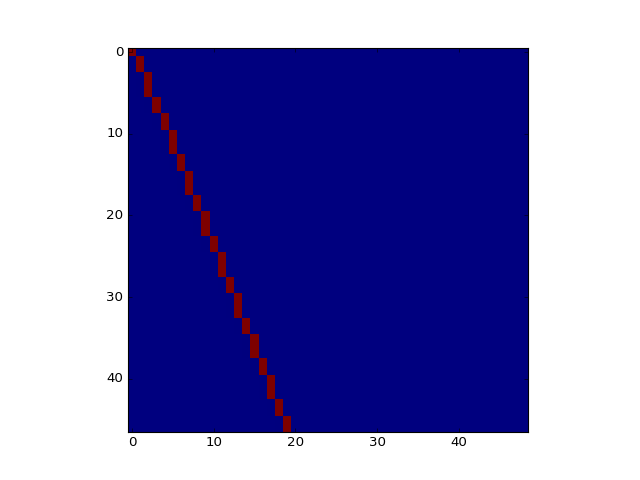

In [8]:
# Demonstrate how to visualize an event by converting to rectangular image
t = generate_trap_track(range(3, 50))
im = convert_trap_to_image(t)
plt.figure()
plt.imshow(im, interpolation='none')

## Training single-track

In [9]:
# Generate the training data
trap_widths = range(3, 50)
trap_tracks = generate_trap_tracks(trap_widths, 50000)
train2_inputs = trap_tracks[:-1]
train2_targets = trap_tracks[1:]

In [10]:
# Instantiate the model
model2 = build_model(trap_widths, 50)
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3)             0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4)             0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 5)             0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 6)             0                                            
___________________________________________________________________________________________

In [11]:
# Train the model
model2.fit(train2_inputs, train2_targets, batch_size=100, nb_epoch=10)
# Get the training set predictions
train2_preds = model2.predict(train2_inputs)

Epoch 1/10
50000/50000 [==============================] - 242s - loss: 30.7834 - dense_47_loss: 0.7405 - dense_48_loss: 0.8434 - dense_49_loss: 0.7822 - dense_50_loss: 0.7251 - dense_51_loss: 0.6790 - dense_52_loss: 0.6209 - dense_53_loss: 0.6285 - dense_54_loss: 0.6135 - dense_55_loss: 0.5616 - dense_56_loss: 0.6053 - dense_57_loss: 0.5763 - dense_58_loss: 0.5766 - dense_59_loss: 0.5725 - dense_60_loss: 0.5641 - dense_61_loss: 0.5918 - dense_62_loss: 0.6010 - dense_63_loss: 0.6007 - dense_64_loss: 0.6036 - dense_65_loss: 0.6382 - dense_66_loss: 0.6400 - dense_67_loss: 0.6420 - dense_68_loss: 0.6416 - dense_69_loss: 0.6455 - dense_70_loss: 0.6582 - dense_71_loss: 0.6374 - dense_72_loss: 0.6427 - dense_73_loss: 0.6656 - dense_74_loss: 0.6522 - dense_75_loss: 0.6681 - dense_76_loss: 0.6688 - dense_77_loss: 0.6922 - dense_78_loss: 0.7014 - dense_79_loss: 0.6906 - dense_80_loss: 0.6871 - dense_81_loss: 0.7047 - dense_82_loss: 0.7082 - dense_83_loss: 0.7185 - dense_84_loss: 0.7211 - dense_8

(46, 48)
(46, 49)


<IPython.core.display.Javascript object>


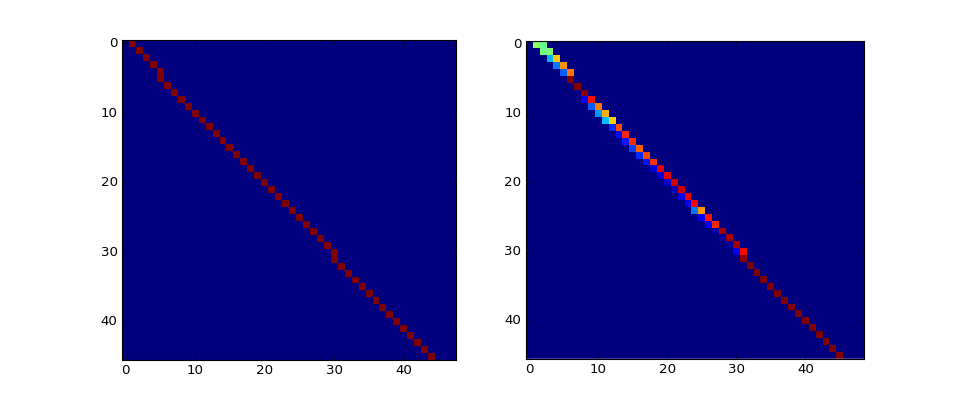

In [12]:
# Visualize one event
display_idx = 432
# Pick out the data
event = get_square_image([x[display_idx] for x in train2_inputs])
print(event.shape)
pred = get_square_image([x[display_idx] for x in train2_preds])
print(pred.shape)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(event, interpolation='none')
plt.subplot(122)
plt.imshow(pred, interpolation='none')

## Still to do

- Add track backgrounds
  - A little trickier to implement